In [1]:
!mkdir CamVid
%cd CamVid
!wget https://www.dropbox.com/s/pxcz2wdz04zxocq/CamVid.zip?dl=1 -O CamVid.zip
!unzip -qq CamVid.zip
%cd ..
!unzip -qq "Segmentation Models.zip"

/content/CamVid
--2019-12-11 10:22:36--  https://www.dropbox.com/s/pxcz2wdz04zxocq/CamVid.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/pxcz2wdz04zxocq/CamVid.zip [following]
--2019-12-11 10:22:37--  https://www.dropbox.com/s/dl/pxcz2wdz04zxocq/CamVid.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd45b2c8edaadc5032f3f4ca171.dl.dropboxusercontent.com/cd/0/get/AuCxdInyhW_AymSZ_esWF-bf2DeXxretn5Xq13uPlDrOS8Qxa5nlmds8pILjDpwUc4JjClaKUFI1F0RbFoS34A0PDOIRNGfYKBUOqkFYf7G3Qg/file?dl=1# [following]
--2019-12-11 10:22:37--  https://ucd45b2c8edaadc5032f3f4ca171.dl.dropboxusercontent.com/cd/0/get/AuCxdInyhW_AymSZ_esWF-bf2DeXxretn5Xq13uPlDrOS8Qxa5nlmds8pILjDpwUc4JjClaKUFI1F0RbFoS34A0PDOIRNGfYKBUOqkFYf7G3Qg/file?dl=1
Re

In [0]:
import torch
from config import *
from glob import glob
from src.model import *
from src.camvid_pipeline import *
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from matplotlib import pyplot as plt
from torchvision.transforms import ToPILImage

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [0]:
train_images = sorted(glob('/content/CamVid/train/*'))
train_labels = sorted(glob('/content/CamVid/trainannot/*'))
val_images = sorted(glob('/content/CamVid/val/*'))
val_labels = sorted(glob('/content/CamVid/valannot/*'))
test_images = sorted(glob('/content/CamVid/test/*'))
test_labels = sorted(glob('/content/CamVid/testannot/*'))

In [0]:
train_dataset = CamVidDataset(train_images, train_labels, 512, 512)
val_dataset = CamVidDataset(val_images, val_labels, 512, 512)
test_dataset = CamVidDataset(test_images, test_labels, 512, 512)

In [0]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)

In [6]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([16, 3, 512, 512]), torch.Size([16, 512, 512]))

In [0]:
enet = Enet(12)
enet = enet.to(device)

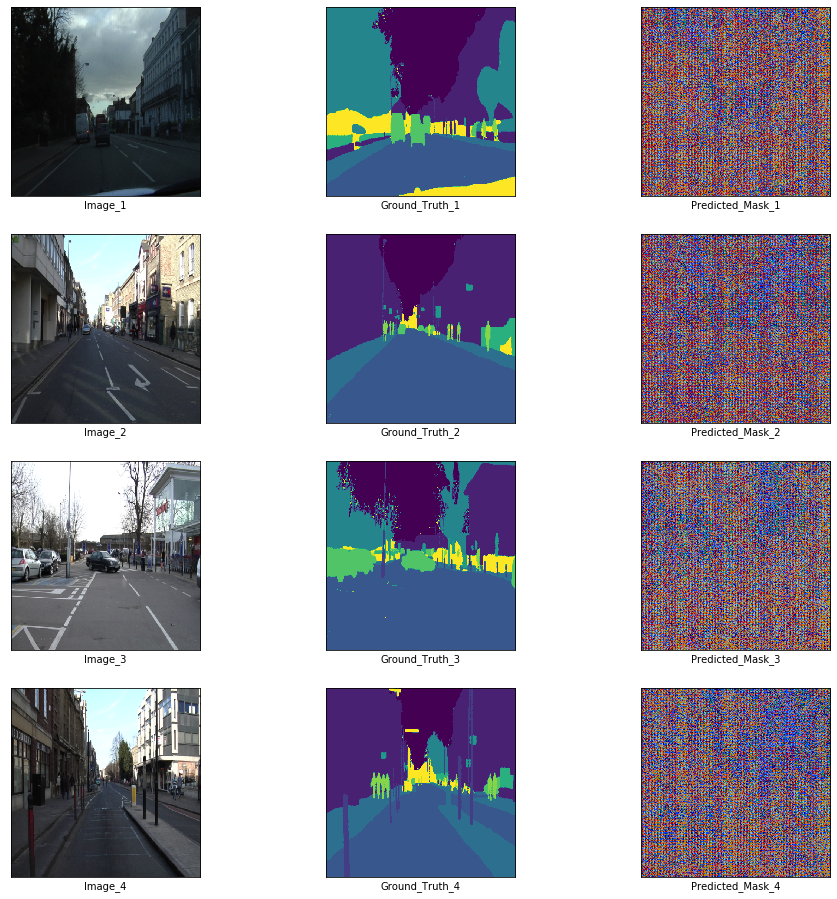

In [8]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 1
for i, ax in enumerate(axes.flat):
    if i % 3 == 0:
        ax.imshow(ToPILImage()(x_batch[c]))
        ax.set_xlabel('Image_' + str(c))
    elif i % 3 == 1:
        ax.imshow(y_batch[c])
        ax.set_xlabel('Ground_Truth_' + str(c))
    elif i % 3 == 2:
        ax.imshow(predict_rgb(enet, x_batch[c].unsqueeze(0).to(device)))
        ax.set_xlabel('Predicted_Mask_' + str(c))
        c += 1
plt.show()

In [0]:
class_weights = get_class_weights(train_loader, 12)

In [0]:
criterion = CrossEntropyLoss()
optimizer = Adam(
    enet.parameters(),
    lr=5e-4,
    weight_decay=2e-4
)

In [11]:
train_loss_history, val_loss_history = train(
    enet, train_loader, val_loader,
    device, criterion, optimizer,
    len(train_images) // 16,
    len(val_images) // 16, 5,
    './', 'enet-model', 50
)

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 52.0652961730957


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 2.436054229736328
Epoch 2



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 44.55814337730408


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 5.926746368408203
Epoch 3



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 37.64187288284302


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 7.680830001831055
Epoch 4



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 32.40213966369629


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 9.24750804901123
Epoch 5



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 28.31266677379608


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 8.4774169921875
Epoch 6



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 25.752286195755005


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 8.864091873168945
Epoch 7



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 24.035030603408813


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 8.698701858520508
Epoch 8



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 22.509020030498505


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 7.845836639404297
Epoch 9



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 21.463788747787476


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 7.472916603088379
Epoch 10



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 20.655702888965607


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 8.022370338439941
Epoch 11



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 19.267381012439728


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 7.642489433288574
Epoch 12



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 18.37090653181076


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 6.007508277893066
Epoch 13



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 17.627463817596436


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 6.4369611740112305
Epoch 14



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 16.340035796165466


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 4.646720886230469
Epoch 15



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 16.504523634910583


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 2.424691915512085
Epoch 16



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 15.469253063201904


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 3.427347421646118
Epoch 17



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 14.504486501216888


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 2.6640498638153076
Epoch 18



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 14.403683245182037


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 3.7609760761260986
Epoch 19



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 13.497256457805634


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 2.717529535293579
Epoch 20



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 13.716701626777649


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 2.6111137866973877
Epoch 21



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 13.146135151386261


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 0.6206948757171631
Epoch 22



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 12.518845915794373


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 2.8727874755859375
Epoch 23



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 12.974334299564362


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 2.712737560272217
Epoch 24



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 12.618107199668884


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 1.872286319732666
Epoch 25



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 11.725935637950897


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 2.9390180110931396
Epoch 26



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 11.994923561811447


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 2.5394339561462402
Epoch 27



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 11.997483372688293


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 1.1811082363128662
Epoch 28



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 11.640700846910477


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 2.3118295669555664
Epoch 29



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 12.058021903038025


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 0.7963521480560303
Epoch 30



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 11.14459091424942


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 1.333909034729004
Epoch 31



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 11.42369094491005


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 2.02595591545105
Epoch 32



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 11.019880503416061


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 0.6199009418487549
Epoch 33



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 10.933896690607071


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 1.179128646850586
Epoch 34



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 10.927759855985641


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 1.2904317378997803
Epoch 35



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 10.78343152999878


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 0.5843322277069092
Epoch 36



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 10.938981235027313


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 1.931678295135498
Epoch 37



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 10.852896273136139


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 0.88106369972229
Epoch 38



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 10.647018790245056


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 2.108849287033081
Epoch 39



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 10.642788410186768


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 0.6467108726501465
Epoch 40



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 10.47987711429596


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: -0.3195369243621826
Epoch 41



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 10.003458589315414


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 1.136045217514038
Epoch 42



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 9.715956032276154


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: -0.5335371494293213
Epoch 43



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 10.282496213912964


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 1.5872416496276855
Epoch 44



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 10.312272906303406


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 0.9175939559936523
Epoch 45



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 9.879595577716827


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 0.1054224967956543
Epoch 46



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 9.823135316371918


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 0.36910057067871094
Epoch 47



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 9.561199277639389


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 0.19443821907043457
Epoch 48



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 9.495932072401047


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: -0.1040654182434082
Epoch 49



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 9.259121060371399


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 0.37179112434387207
Epoch 50



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 9.136612057685852


100%|██████████| 6/6 [00:23<00:00,  3.89s/it]



Validation Loss: -0.29712510108947754

Training Done.
Training Mean Loss: 15.940734
Validation Mean Loss: 3.017748


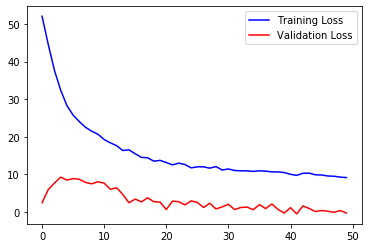

In [12]:
plt.plot(train_loss_history, color = 'b', label = 'Training Loss')
plt.plot(val_loss_history, color = 'r', label = 'Validation Loss')
plt.legend()
plt.show()

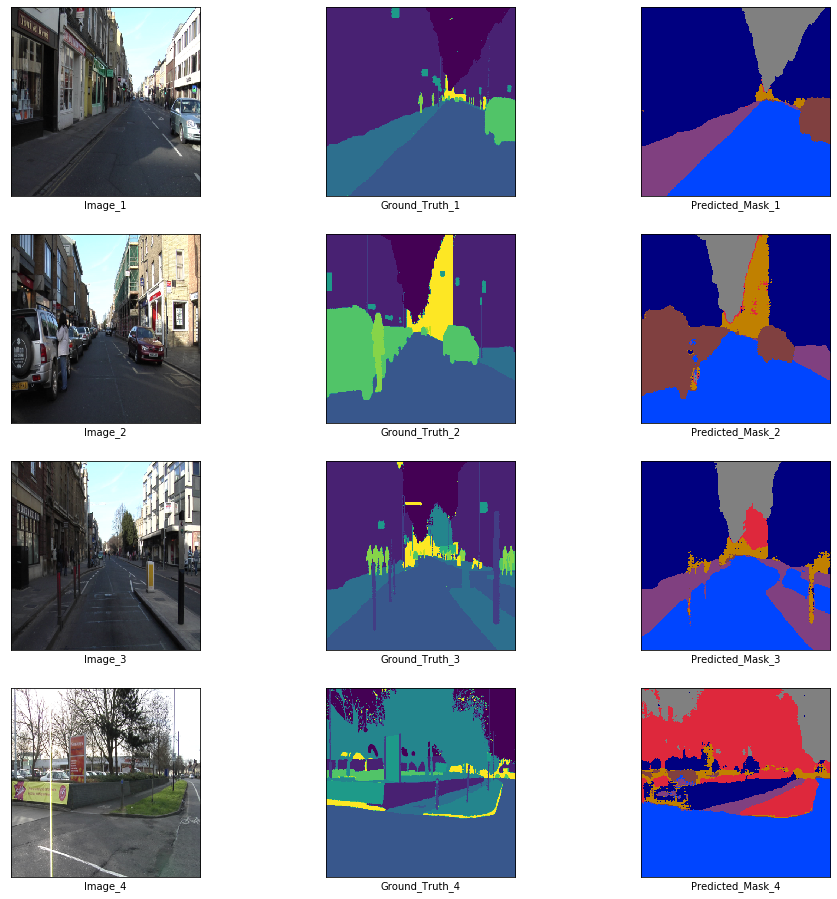

In [13]:
x_batch, y_batch = next(iter(train_loader))
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 1
for i, ax in enumerate(axes.flat):
    if i % 3 == 0:
        ax.imshow(ToPILImage()(x_batch[c]))
        ax.set_xlabel('Image_' + str(c))
    elif i % 3 == 1:
        ax.imshow(y_batch[c])
        ax.set_xlabel('Ground_Truth_' + str(c))
    elif i % 3 == 2:
        ax.imshow(predict_rgb(enet, x_batch[c].unsqueeze(0).to(device)))
        ax.set_xlabel('Predicted_Mask_' + str(c))
        c += 1
plt.show()

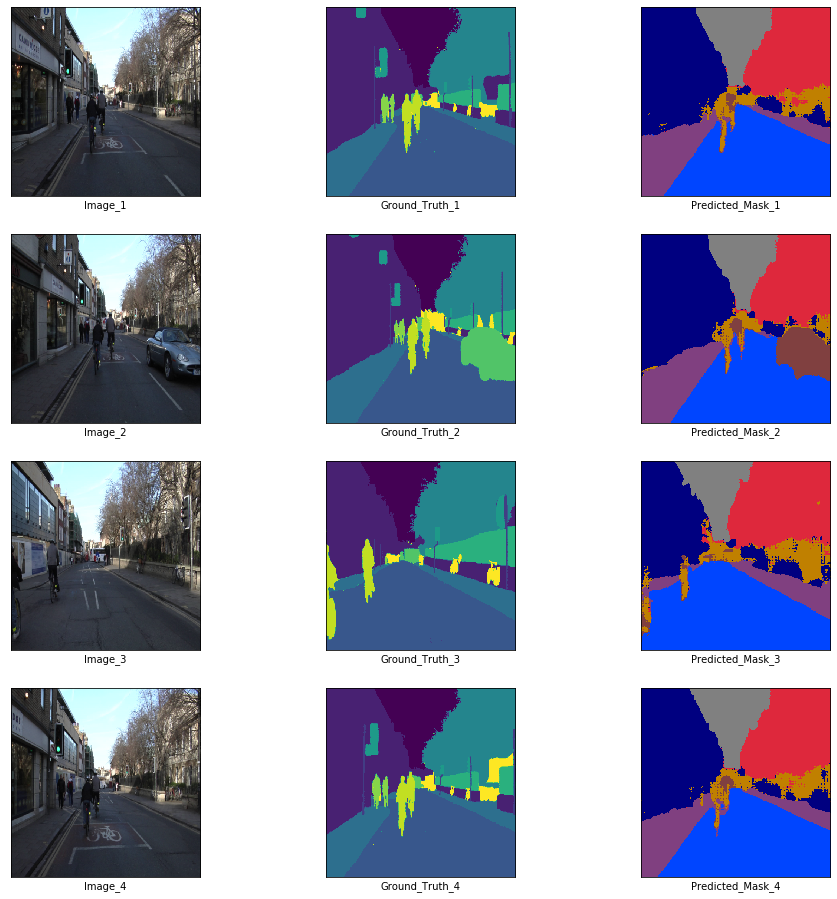

In [14]:
x_batch, y_batch = next(iter(val_loader))
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 1
for i, ax in enumerate(axes.flat):
    if i % 3 == 0:
        ax.imshow(ToPILImage()(x_batch[c]))
        ax.set_xlabel('Image_' + str(c))
    elif i % 3 == 1:
        ax.imshow(y_batch[c])
        ax.set_xlabel('Ground_Truth_' + str(c))
    elif i % 3 == 2:
        ax.imshow(predict_rgb(enet, x_batch[c].unsqueeze(0).to(device)))
        ax.set_xlabel('Predicted_Mask_' + str(c))
        c += 1
plt.show()